In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import streamlit as st

In [2]:
# using raw data for this step
data=pd.read_csv(r'D:\Data Science\data world ds\task 4\Data\credit_card_transactions.csv')

In [3]:
from sklearn.ensemble import IsolationForest

In [4]:
# Define Isolation Forest model
iso_forest = IsolationForest(contamination=0.02, random_state=42)

# Fit model on transaction amount
data['Outlier_Score'] = iso_forest.fit_predict(data[['amt']])

In [5]:
# Mark anomalies
data['Anomaly'] = data['Outlier_Score'].apply(lambda x: 'Outlier' if x == -1 else 'Normal')

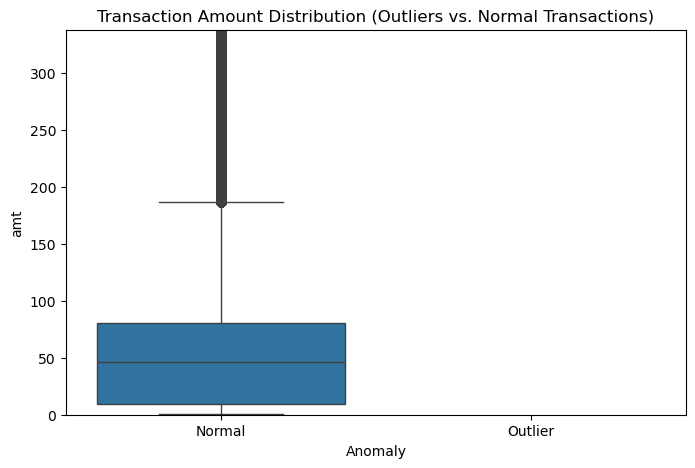

In [7]:
# Plot normal vs anomalous transactions
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['Anomaly'], y=data['amt'])
plt.title("Transaction Amount Distribution (Outliers vs. Normal Transactions)")
plt.ylim(0, data['amt'].quantile(0.98))  # Remove extreme values
plt.show()

2. Customer Segmentation using K-Means & DBSCAN

In [8]:
from sklearn.cluster import  DBSCAN

In [9]:
# Load & Preprocess Data

# Select relevant columns
data= data[['cc_num', 'amt', 'city_pop']]  # Using credit card number, transaction amount, city population

# Aggregate spending per customer (total spent & number of transactions)
customer_summary = data.groupby('cc_num').agg({'amt': ['sum', 'mean', 'count'], 'city_pop': 'mean'}).reset_index()
customer_summary.columns = ['cc_num', 'Total_Spent', 'Avg_Spent', 'Num_Transactions', 'Avg_City_Pop']

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_summary[['Total_Spent', 'Avg_Spent', 'Num_Transactions']])

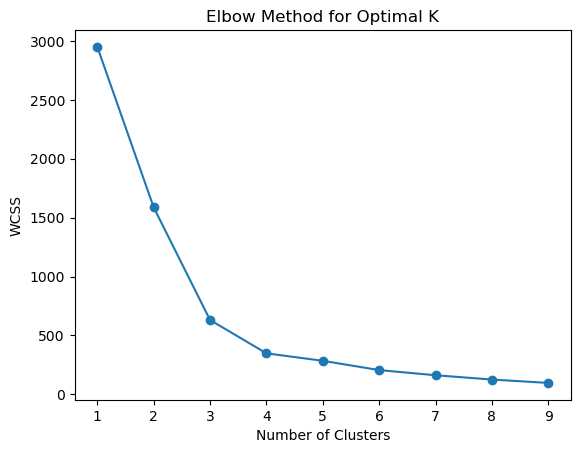

In [10]:
# Finding the optimal K using Elbow Method
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.plot(range(1, 10), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

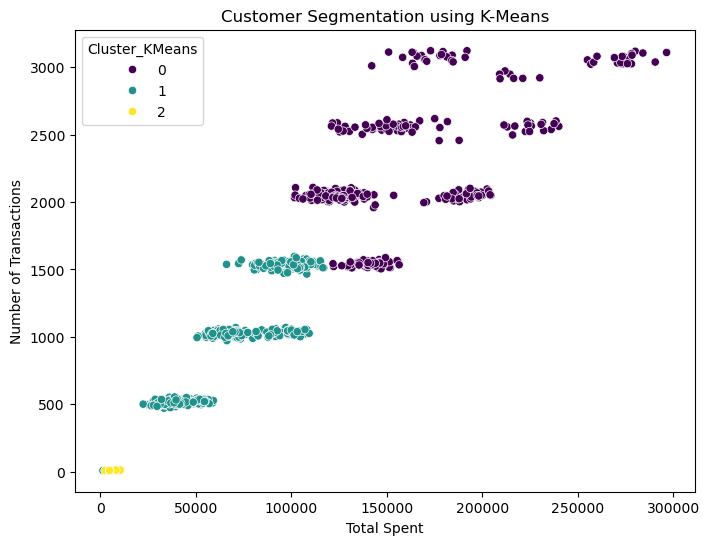

In [11]:
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_summary['Cluster_KMeans'] = kmeans.fit_predict(scaled_data)

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=customer_summary['Total_Spent'], y=customer_summary['Num_Transactions'], hue=customer_summary['Cluster_KMeans'], palette='viridis')
plt.title("Customer Segmentation using K-Means")
plt.xlabel("Total Spent")
plt.ylabel("Number of Transactions")
plt.show()


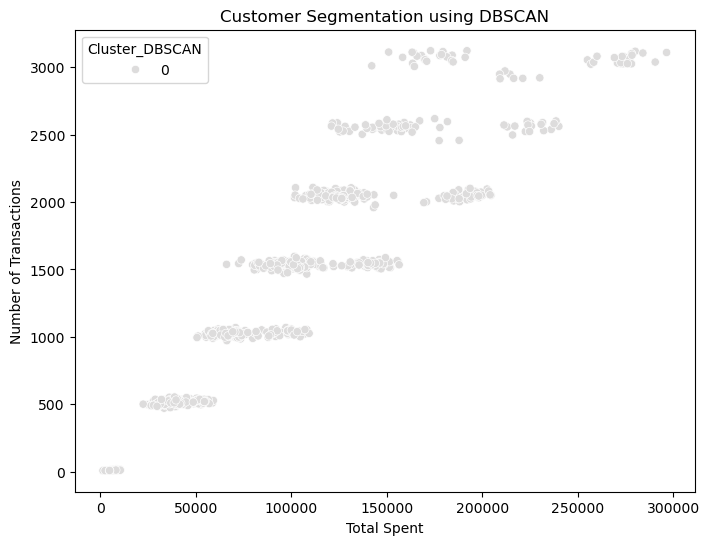

In [12]:
# Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  # Adjust parameters as needed
customer_summary['Cluster_DBSCAN'] = dbscan.fit_predict(scaled_data)

# Visualize DBSCAN clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=customer_summary['Total_Spent'], y=customer_summary['Num_Transactions'], hue=customer_summary['Cluster_DBSCAN'], palette='coolwarm')
plt.title("Customer Segmentation using DBSCAN")
plt.xlabel("Total Spent")
plt.ylabel("Number of Transactions")
plt.show()


In [13]:
# Count customers per cluster
print(customer_summary.groupby('Cluster_KMeans')[['Total_Spent']].mean())
print(customer_summary['Cluster_DBSCAN'].value_counts())  # Check how many outliers detected


                  Total_Spent
Cluster_KMeans               
0               160224.074277
1                66170.988513
2                 6021.595616
Cluster_DBSCAN
0    983
Name: count, dtype: int64


3. Association Rule Mining (Apriori, FP-Growth)


In [14]:
#  Prepare Data for Market Basket Analysis
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder



In [15]:
df = pd.read_csv(r"D:\Data Science\data world ds\task 4\Data\credit_card_transactions_cleaned.csv")

In [16]:
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces
df = df[['trans_num', 'category']]


In [17]:
# Select relevant columns
df = df[['trans_num', 'category']]  # Transaction ID & Purchase Category

# Convert transactions into a basket format
basket = df.groupby(['trans_num', 'category']).size().unstack().fillna(0)

In [18]:
# Convert to binary format (1 = purchased, 0 = not purchased)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Display sample basket
print(basket.head())

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15836\3178159488.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


category                          entertainment  food_dining  gas_transport  \
trans_num                                                                     
00000ecad06b03d3a8d34b4e30b5ce3b              0            0              0   
0000246d803d5f465cc322d8a3c3528f              0            0              0   
0000258ae973a6199fca79d94947672f              0            0              0   
0000307898b3352b5a0d66015d362794              1            0              0   
0000425d184356a21be4b39933c2c0ea              0            0              0   

category                          grocery_net  grocery_pos  health_fitness  \
trans_num                                                                    
00000ecad06b03d3a8d34b4e30b5ce3b            0            0               0   
0000246d803d5f465cc322d8a3c3528f            0            0               0   
0000258ae973a6199fca79d94947672f            0            1               0   
0000307898b3352b5a0d66015d362794            0           

In [19]:
# Apply Apriori Algorithm

df = df[['trans_num', 'category']]

# Convert transactions into a basket format
basket = df.groupby(['trans_num', 'category']).size().unstack().fillna(0)

# Convert to Boolean (True/False)
basket = basket.applymap(lambda x: x > 0)

# Apply Apriori Algorithm with lower support
frequent_itemsets = apriori(basket, min_support=0.001, use_colnames=True)

# Check if frequent itemsets were found
if not frequent_itemsets.empty:
    # Generate Association Rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
    print(rules)
else:
    print("No frequent itemsets found. Try lowering min_support.")
# Display top rules
rules.sort_values(by='lift', ascending=False).head(10)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15836\3580276991.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: x > 0)


Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


In [20]:
# Find frequent itemsets using FP-Growth
frequent_itemsets_fp = fpgrowth(basket, min_support=0.01, use_colnames=True)

# Generate association rules
rules_fp = association_rules(frequent_itemsets_fp, metric="lift", min_threshold=1.0)

# Display top rules
print(rules_fp.sort_values(by='lift', ascending=False).head(10))


Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


4. Correlation with Economic Factors (Inflation, Interest Rates)

In [21]:
# Load The dataset
economic_data= pd.read_csv(r'D:\Data Science\data world ds\task 4\Data\us_economic_data_2019_2020.csv')
df = pd.read_csv(r"D:\Data Science\data world ds\task 4\Data\credit_card_transactions_cleaned.csv")


In [22]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])  # Ensure it's datetime
df['YearMonth'] = df['trans_date_trans_time'].dt.to_period('M')  # Convert to Year-Month



In [24]:
economic_data['Date'] = pd.to_datetime(economic_data['DATE'])  # Ensure it's datetime
economic_data['YearMonth'] = economic_data['DATE'].dt.to_period('M')  # Convert to Year-Month

c:\ProgramData\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\ProgramData\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\ProgramData\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


AttributeError: Can only use .dt accessor with datetimelike values